In [1]:
import pandas as pd
import numpy as np
import yaml
import gzip
from scripts.data_processor import DataProcessor


In [2]:

def get_config(file_name):

    with open(file_name, 'r', encoding="UTF-8") as stream:
        config = yaml.safe_load(stream)
    return config


def parse_metadata(file_path):
    data = {}
    with gzip.open(file_path, 'rt') as f:
        lines = f.readlines()

    for line in lines:
        splited = line.split('\t', 1)
        if len(splited) >= 2:
            # Only include lines where the first part is '!Sample_title' or does not start with '!'
            if splited[0].strip() == '!Sample_title' or not splited[0].lstrip().startswith('!'):
                data[splited[0].strip()] = splited[1].strip().strip(
                    '"').split("\t")

    df = pd.DataFrame.from_dict(data, orient='index').transpose()
    df.drop(columns=['!Sample_title'], inplace=True)
    df.drop('"ID_REF"', inplace=True, axis=1)
    df = df.apply(pd.to_numeric, errors='coerce')
    return df


def retrieve_data():

    config = get_config('../config.yaml')
    lung3 = config['lung3']
    gene = config['gene']

    lung3_df = pd.read_csv(lung3)

    gene_df = pd.read_csv(gene, sep= '\t', comment= "!")
    gene_df.set_index('ID_REF', inplace=True)
    gene_df = gene_df.T
    gene_df.reset_index(drop=True, inplace=True)
    combined_df = lung3_df.merge(gene_df, left_index=True, right_index=True)
    return combined_df


 ### <span style="background-color: lightyellow;"> Initial Data Preprocessing</span>

In [3]:
def sub_classification(histology):
    if "Carcinoma" in histology:
        return 'Carcinoma'
    elif "Adenocarcinoma" in histology:
        return 'Adenocarcinoma'
    else:
        return 'Others'

dataset = retrieve_data()
y = dataset['characteristics.tag.histology'].apply(lambda x: sub_classification(x))
dataset.drop(columns='characteristics.tag.histology',inplace=True)

data_processor = DataProcessor(dataset)
data_processor.remove_non_related_columns()
data_processor.impute_not_available_values('characteristics.tag.grade')
data_processor.drop_nan_columns(35)

data_processor.cramerV(y, 0)
covarrianced_columns = data_processor.covarrianced_columns
removed_catagorical_features = set(data_processor.find_cols_on_type('object')) - set(covarrianced_columns)
data_processor.drop_columns(column_list = list(removed_catagorical_features))
data_processor.selecting_high_variance_gene_expression(95)
dataset = data_processor.dataframe
dataset['classes'] = y
dataset.shape

/homes/rmeshita/Documents/Programming_6/dask/pandas_workflow/scripts/data_processor.py:198: RuntimeWarning: Unable to calculate Cramér's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/dask/pandas_workflow/scripts/data_processor.py:198: RuntimeWarning: Unable to calculate Cramér's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/dask/pandas_workflow/scripts/data_processor.py:198: RuntimeWarning: Unable to calculate Cramér's V using bias correction. Consider not using bias correction
  warnings.warn(
/homes/rmeshita/Documents/Programming_6/dask/pandas_workflow/scripts/data_processor.py:124: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  

(89, 60611)

### <span style="background-color: lightyellow;">EDA Task</span>

- Calculate summary statistics (e.g., mean, median, standard deviation) for clinical variables and gene expression data.
- Identify the top 10 most variable genes across patients.
- Group patients by clinical variables and compute the average expression of selected genes.
- Visualize the distribution of the target variable (TumorSubtype).

In [4]:
def calculate_statistics(df):

    numerical_cols = df.select_dtypes(include=[np.number])

    describe_df = numerical_cols.describe().T
    describe_df['median'] = numerical_cols.median()

    stats_df = describe_df[['mean', 'median', 'std']]


    return stats_df

In [5]:
# Calculate summary statistics (e.g., mean, median, standard deviation) for clinical variables and gene expression data.
stats_df = calculate_statistics(dataset)

In [6]:
# Identify the top 10 most variable genes across patients.
import re
variances = {}
gens = [col for col in dataset.columns if re.match(r'.*_at$',col)]
for col in gens:
    data = dataset[col]
    log_normalized = np.log1p(data)
    variances[col] = log_normalized.var()


variances = list(sorted(variances.items(), key=lambda item: item[1], reverse=True))
top_var_genes = [gene for gene, _ in variances[:10]]
top_var_genes

['merck2-AA622265_at',
 'merck2-AK074475_at',
 'merck-NM_005362_s_at',
 'merck-CR749383_at',
 'merck-NM_003125_at',
 'merck2-NM_005555_at',
 'merck-NM_000673_at',
 'merck2-BM983732_at',
 'merck2-NM_012397_at',
 'merck-AJ001612_at']

In [7]:
# - Group patients by clinical variables and compute the average expression of selected genes.
dataset.groupby("characteristics.tag.gender")[top_var_genes].mean()

,merck2-AA622265_at,merck2-AK074475_at,merck-NM_005362_s_at,merck-CR749383_at,merck-NM_003125_at,merck2-NM_005555_at,merck-NM_000673_at,merck2-BM983732_at,merck2-NM_012397_at,merck-AJ001612_at
characteristics.tag.gender,,,,,,,,,,
F,6.285481,3.929155,3.833551,10.620725,6.335944,5.081515,2.828152,9.848369,2.951356,4.006092
M,5.398513,5.578471,6.216304,2.820994,7.844238,6.613083,4.760859,2.650069,4.832564,3.557385


<Axes: xlabel='classes'>

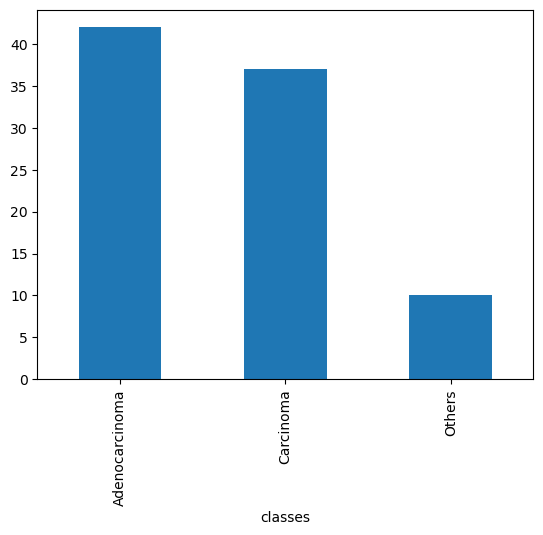

In [8]:
# - Visualize the distribution of the target variable (TumorSubtype).

dataset['classes'].value_counts().plot.bar()